### Summery
<pre>
Author           : Sivananda Reddy Kopperla
Project Name     : Detection of Pneumonia from Chest X-Ray Images using Convolutional Neural Network, 
                   and Transfer Learning.
Description      : 1. Detected Pneumonia from Chest X-Ray images using Custom Deep Convololutional Neural Network and by
                      retraining pretrained model “InceptionV3” and Bottleneck "VGG" with 5216 images of X-ray.
                   2. For retraining removed output layers, freezed first few layers and fine-tuned model for 
                      two new label classes (Pneumonia and Normal).
                   3. With Custom Deep Convololutional Neural Network attained testing accuracy 93.43% and loss 0.24.
Tools/Library    : Python, Keras, TensorFlow
</pre>

#### Dataset
<pre>
Dataset Name     : Chest X-Ray Images (Pneumonia)
Dataset Link     : <a href=https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia>Chest X-Ray Images (Pneumonia) Dataset (Kaggle)</a>
                 : <a href=https://data.mendeley.com/datasets/rscbjbr9sj/2>Chest X-Ray Images (Pneumonia) Dataset (Original Dataset)</a>
Original Paper   : <a href=https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5>Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning</a>
                   (Daniel S. Kermany, Michael Goldbaum, Wenjia Cai, M. Anthony Lewis, Huimin Xia, Kang Zhang)
                   https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
</pre>

<pre>
<b>Dataset Details</b>
Dataset Name            : Chest X-Ray Images (Pneumonia)
Number of Class         : 2
Number/Size of Images   : Total      : 5856 (1.27 Gigabyte (GB))
                          Training   : 5216 (1.18 Gigabyte (GB))
                          Validation : 16  (3.6 Megabyte (MB))
                          Testing    : 624  (83.7 Megabyte (MB))

<b>Model Parameters</b>
Machine Learning Library: Keras
Base Model              : InceptionV3 && VGG16
Optimizers              : Adam
Loss Function           : categorical_crossentropy

<b>For Custom Deep Convolutional Neural Network : </b>
<b>Training Parameters</b>
Batch Size              : 16
Number of Epochs        : 21
Training Time           : 80 Minutes

<b>Output (Prediction/ Recognition / Classification Metrics)</b>
<!--<b>Validation</b>-->
<b>Testing</b>
Accuracy Score          : 93.43%
Loss                    : 0.24
Precision               : 89%
Recall                  : 89% 
<!--Specificity             : -->
</pre>

In [1]:
#inbuild libraries
import os
import random
import time
import datetime
import shutil
import gc
import re

#installed libs
import cv2
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

import keras
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import maxnorm
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf

K.set_image_dim_ordering('th')
%matplotlib inline

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

In [3]:
input_directory = r"/home/siva/Desktop/assignments/chest_xray/"
training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"
figure_directory = input_directory + r"figures"

if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)

In [4]:
from pathlib import Path

In [5]:
classes = os.listdir(training_dir)
class_count = len(classes)
print("classes:", classes)
print("class_count", class_count)

classes: ['PNEUMONIA', 'NORMAL']
class_count 2


In [6]:
pneumonia_images_path = training_dir+"/"+classes[0]
narmal_images_path = training_dir+"/"+classes[1]

In [7]:
pneumonia_images_lst = []
for img in os.listdir(pneumonia_images_path): pneumonia_images_lst.append(pneumonia_images_path+"/"+img)
narmal_images_lst = []
for img in os.listdir(narmal_images_path): narmal_images_lst.append(narmal_images_path+"/"+img)

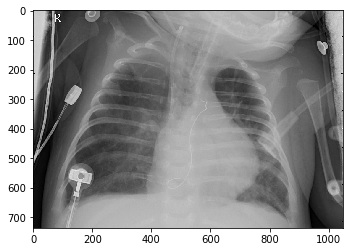

In [8]:
pneumonia_image = cv2.imread(pneumonia_images_lst[0])
plt.imshow(pneumonia_image)

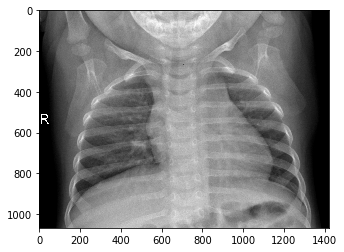

In [9]:
narmal_image = cv2.imread(narmal_images_lst[0])
plt.imshow(narmal_image)

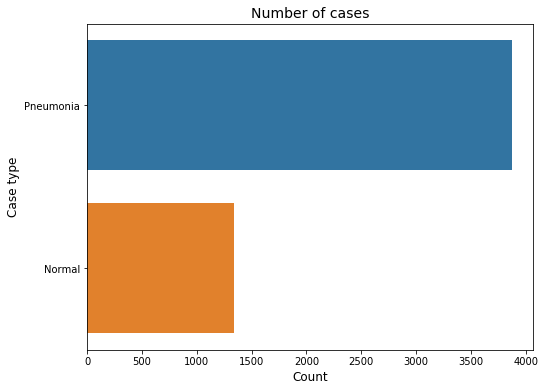

In [10]:
# Plot the results 
plt.figure(figsize=(8,6))
sns.barplot(x=[3876, 1342], y=['Pneumonia', 'Normal'])
plt.title('Number of cases', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Case type', fontsize=12)
plt.show()

In [11]:
rescale = 1./255
target_size = (150, 150)
batch_size = 16
class_mode = "categorical"

train_datagen = ImageDataGenerator(rescale=rescale, shear_range=0.2,
                                    zoom_range=0.2, horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(training_dir, target_size=target_size,
                                                    class_mode=class_mode, batch_size=batch_size,
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
                                                validation_dir,
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=batch_size,
                                                shuffle = False)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
                                                testing_dir,
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=batch_size,
                                                shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [13]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [14]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True

def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)

In [15]:
main_model_dir =  r"/home/siva/Desktop/assignments/chest_xray/models/"
main_log_dir =  r"/home/siva/Desktop/assignments/chest_xray/logs/"

clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)

model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

Removing empty folder: /home/siva/Desktop/assignments/chest_xray/models/.ipynb_checkpoints


In [16]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try: del model
        except: return False  
    tf.reset_default_graph()    
    K.clear_session()    
    gc.collect()    
    return True

# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

In [17]:
reset_graph()
reset_callbacks()

### Configuring the Callbacks

In [18]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    verbose=1,
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
print("Set Callbacks at ", date_time(1))

Set Callbacks at  Timestamp: 2019-04-03 19:57:48


### Creating CNN

In [19]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='softmax'))


print(model.summary())

W0403 19:57:48.967784 47548701609600 deprecation.py:506] From /root/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 37, 37)        18496     
__________

In [20]:
print("Starting Trainning Model", date_time(1))

steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100

model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

print("Completed Model Trainning", date_time(1))

Starting Trainning Model Timestamp: 2019-04-03 19:57:49
Epoch 1/100
326/326 [==============================] - 232s 711ms/step - loss: 0.5847 - acc: 0.7425 - val_loss: 0.8511 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to /home/siva/Desktop/assignments/chest_xray/models/2019-04-03 19-57-46/01-val_acc-0.50-val_loss-0.85.hdf5
Epoch 2/100
326/326 [==============================] - 232s 713ms/step - loss: 0.5751 - acc: 0.7429 - val_loss: 0.9134 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/100
326/326 [==============================] - 230s 705ms/step - loss: 0.5753 - acc: 0.7429 - val_loss: 0.8422 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/100
326/326 [==============================] - 239s 732ms/step - loss: 0.5756 - acc: 0.7429 - val_loss: 0.8341 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.50000
Epoch 5/100
326/326 [==============================] - 240s 735ms/step

In [21]:
model.save_weights('simple_cnn.h5')
model.metrics_names

['loss', 'acc']

In [22]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
39/39 [==============================] - 16s 421ms/step
Loss     : 0.24  
Accuracy : 93.43%


In [23]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results
39/39 [==============================] - 9s 241ms/step


In [24]:
precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 89.83%
Recall        : 92.82%
F1-Score      : 91.30%
------------------------------------------------------------------------------------------





In [25]:
cls_report_print = classification_report(y_true, y_pred, target_names=classes)

print("\n\n")
print("-"*90)
print("Report ")
print("-"*90)
print(cls_report_print)
print("-"*90)




------------------------------------------------------------------------------------------
Report 
------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

  PNEUMONIA       0.87      0.82      0.85       234
     NORMAL       0.90      0.93      0.91       390

avg / total       0.89      0.89      0.89       624

------------------------------------------------------------------------------------------


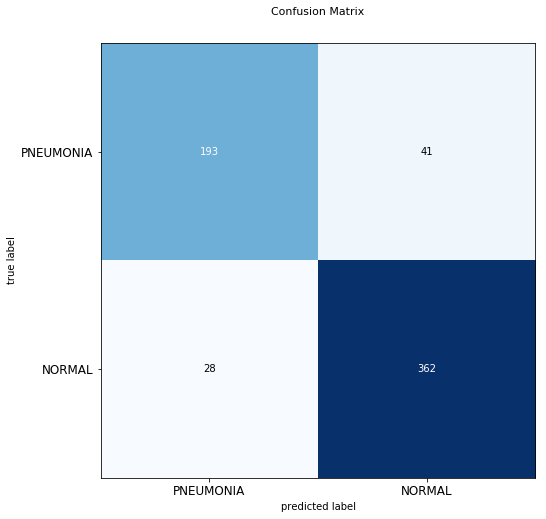

In [26]:
CM = confusion_matrix(y_true, y_pred)
image_file_name_CM = figure_directory+"/CM"
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8),cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=11)
fig.savefig(image_file_name_CM, dpi=100)
plt.show()
    

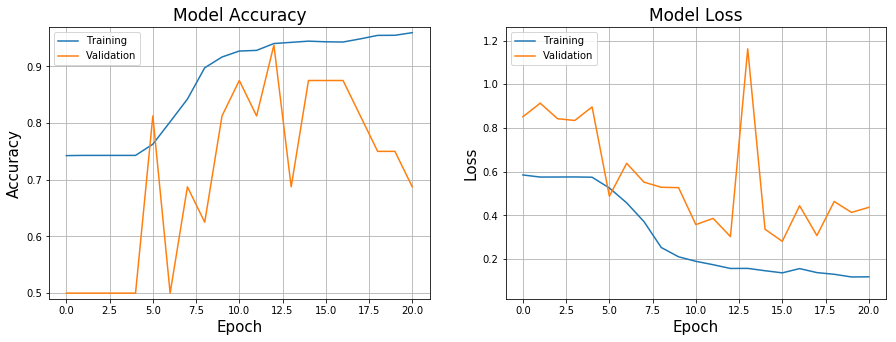

In [27]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()                        

### Bottleneck VGG

In [28]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import applications

In [29]:
rescale = 1./255
target_size = (150, 150)
batch_size = 16
class_mode = None

train_datagen = ImageDataGenerator(rescale=rescale, shear_range=0.2,
                                    zoom_range=0.2, horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(training_dir, target_size=target_size,
                                                    class_mode=class_mode, batch_size=batch_size,
                                                    shuffle=False)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
                                                validation_dir,
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=batch_size,
                                                shuffle = False)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
                                                testing_dir,
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=batch_size,
                                                shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [32]:
reset_graph()
reset_callbacks()

In [33]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet') 

In [34]:
 bottleneck_features_train = model_vgg.predict_generator(train_generator, len(train_generator), verbose = 1)  

326/326 [==============================] - 589s 2s/step


In [35]:
np.save('bottleneck_features_train.npy', bottleneck_features_train) 

In [36]:
bottleneck_features_validation = model_vgg.predict_generator(  
     validation_generator, len(validation_generator),verbose = 1)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 

1/1 [==============================] - 2s 2s/step


In [37]:
bottleneck_features_test = model_vgg.predict_generator(  
     test_generator, len(test_generator),verbose = 1)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 

39/39 [==============================] - 74s 2s/step


In [38]:
from keras.utils.np_utils import to_categorical  
rescale = 1./255
target_size = (150, 150)
batch_size = 16
class_mode = 'categorical'

train_datagen_top = ImageDataGenerator(rescale=rescale, shear_range=0.2,
                                    zoom_range=0.2, horizontal_flip=True)

train_generator_top = train_datagen_top.flow_from_directory(training_dir, target_size=target_size,
                                                    class_mode=class_mode, batch_size=batch_size,
                                                    shuffle=False)

nb_train_samples = len(train_generator_top.filenames)  
num_classes = len(train_generator_top.class_indices) 

train_data = np.load('bottleneck_features_train.npy')

train_labels = train_generator_top.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)  

    
validation_datagen_top = ImageDataGenerator(rescale=rescale)

validation_generator_top = validation_datagen_top.flow_from_directory(
                                                validation_dir,
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=batch_size,
                                                shuffle = False)


nb_validation_samples = len(validation_generator_top.filenames)  

validation_data = np.load('bottleneck_features_validation.npy')  

validation_labels = validation_generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes) 

test_datagen_top = ImageDataGenerator(rescale=rescale)

test_generator_top = test_datagen_top.flow_from_directory(
                                                testing_dir,
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=batch_size,
                                                shuffle = False)
test_labels = test_generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes) 

test_data = np.load('bottleneck_features_test.npy') 

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [39]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(5216, 512, 4, 4)
(16, 512, 4, 4)
(624, 512, 4, 4)


In [66]:
model_vgg_bottleneck = Sequential()  
model_vgg_bottleneck.add(Flatten(input_shape=train_data.shape[1:]))
model_vgg_bottleneck.add(Dense(256, activation='relu'))  
model_vgg_bottleneck.add(Dropout(0.5))  
model_vgg_bottleneck.add(Dense(2, activation='sigmoid'))

In [67]:
model_vgg_bottleneck.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 2,097,922
Trainable params: 2,097,922
Non-trainable params: 0
_________________________________________________________________


In [68]:
model_vgg_bottleneck.compile(optimizer='adam',  
              loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
main_model_dir =  r"/home/siva/Desktop/assignments/chest_xray/models_vgg/"
main_log_dir =  r"/home/siva/Desktop/assignments/chest_xray/logs_vgg/"

clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)

model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

In [70]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    verbose=1,
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)

tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

In [71]:
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

In [72]:
history_vgg_bottleneck = model_vgg_bottleneck.fit(train_data, train_labels,  
          epochs=50,  
          batch_size=16,
          verbose = 1,
          callbacks=callbacks,
          validation_data=(validation_data, validation_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/50
5216/5216 [==============================] - 8s 1ms/step - loss: 0.5875 - acc: 0.7416 - val_loss: 1.0948 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to /home/siva/Desktop/assignments/chest_xray/models_vgg/2019-04-03 21-47-26/01-val_acc-0.50-val_loss-1.09.hdf5
Epoch 2/50
5216/5216 [==============================] - 7s 1ms/step - loss: 0.5116 - acc: 0.7433 - val_loss: 0.9882 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/50
5216/5216 [==============================] - 7s 1ms/step - loss: 0.4987 - acc: 0.7427 - val_loss: 1.0878 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/50
5216/5216 [==============================] - 8s 1ms/step - loss: 0.4898 - acc: 0.7425 - val_loss: 1.3587 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.50000
Epoch 5/50
5216/5216 [==============================] - 8s 1ms/step - loss: 0.4823 - acc

In [73]:
model_vgg_bottleneck.save_weights('bottleneck_fc_model.h5')

In [74]:
(eval_loss, eval_accuracy) = model_vgg_bottleneck.evaluate(  
 test_data, test_labels, batch_size=batch_size, verbose=1)

624/624 [==============================] - 0s 226us/step


In [75]:

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

[INFO] accuracy: 62.50%
[INFO] Loss: 0.9897810725065378
